Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM

Load and Prepare Data

In [ ]:
# Load CSV file
df = pd.read_csv("Dataset.csv")

# Clean NaN in RSI to align with features
df = df.dropna(subset=['RSI'])

Feature Engineering

In [3]:
df['returns'] = df['close'].pct_change().fillna(0)
df['log_returns'] = np.log(df['close'] / df['close'].shift(1)).fillna(0)
df['ema_10'] = df['close'].ewm(span=10).mean()
df['ema_50'] = df['close'].ewm(span=50).mean()
df['price_above_ema'] = (df['close'] > df['ema_50']).astype(int)
df['momentum_10'] = df['close'] - df['close'].shift(10)
df['volume_change'] = df['volume'].pct_change().fillna(0)

features = df[['RSI', 'MACD', 'MACD_Signal', 'volume', 'log_returns',
               'price_above_ema', 'momentum_10', 'volume_change']]

features.replace([np.inf, -np.inf], np.nan, inplace=True)
features = features.dropna()
df = df.loc[features.index]

C:\Users\aminu\AppData\Local\Temp\ipykernel_23872\1190395669.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.replace([np.inf, -np.inf], np.nan, inplace=True)


Feature Scaling

In [4]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

HMM Training

In [5]:
n_states = 3
model = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=1000, random_state=42)
model.fit(scaled_features)

hidden_states = model.predict(scaled_features)
state_probs = model.predict_proba(scaled_features)

df['hidden_state'] = hidden_states

state_means_df = pd.DataFrame(model.means_, columns=features.columns)
bullish_state = state_means_df['RSI'].idxmax()
bearish_state = state_means_df['RSI'].idxmin()

print(f"\n🚀 State Mapping:")
print(f"Bullish state: {bullish_state}")
print(f"Bearish state: {bearish_state}")


🚀 State Mapping:
Bullish state: 2
Bearish state: 1


Strategy Signal Generation

In [6]:
trend_filter = (df['close'] > df['ema_50']).astype(float)
confidence_threshold = 0.7

bullish_confidence = (state_probs[:, bullish_state] > confidence_threshold).astype(float)
bearish_confidence = (state_probs[:, bearish_state] > confidence_threshold).astype(float)

df['position'] = (
    state_probs[:, bullish_state] * bullish_confidence * trend_filter
    - state_probs[:, bearish_state] * bearish_confidence
)

df['position'] = np.clip(df['position'], -1, 1)

Transaction Cost Simulation

In [7]:
transaction_cost = 0.0005
df['position_change'] = df['position'].diff().fillna(0).abs()
df['transaction_cost'] = df['position_change'] * transaction_cost
df['strategy_returns_gross'] = df['position'] * df['returns']
df['strategy_returns_net'] = df['strategy_returns_gross'] - df['transaction_cost']

Performance Metrics

In [8]:
df['cumulative_market'] = (1 + df['returns']).cumprod()
df['cumulative_strategy'] = (1 + df['strategy_returns_net']).cumprod()

def calculate_sharpe(returns, risk_free_rate=0):
    excess_returns = returns - risk_free_rate / 252
    return np.sqrt(252) * np.mean(excess_returns) / np.std(excess_returns)

def calculate_max_drawdown(cumulative_returns):
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

sharpe_ratio = calculate_sharpe(df['strategy_returns_net'])
max_drawdown = calculate_max_drawdown(df['cumulative_strategy'])
total_trades = df['position_change'].sum()
trade_frequency = (total_trades / len(df)) * 100

print(f"\n📊 Final Risk Metrics (With Transaction Cost):")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Trade Frequency: {trade_frequency:.2f}%")



📊 Final Risk Metrics (With Transaction Cost):
Sharpe Ratio: 1.08
Max Drawdown: -8.98%
Trade Frequency: 6.45%


Plot Final Performance

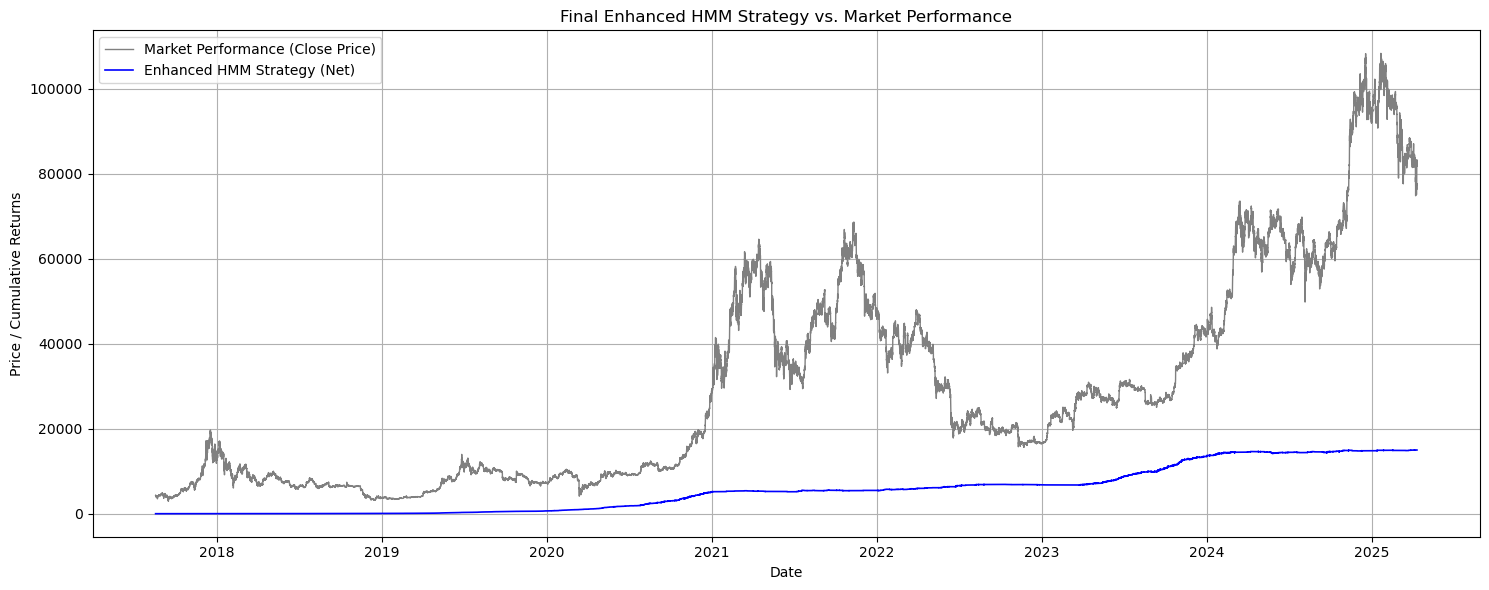

In [9]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%d/%m/%Y %H:%M', errors='coerce')
df = df.dropna(subset=['datetime'])

plt.figure(figsize=(15, 6))
plt.plot(df['datetime'], df['close'], label='Market Performance (Close Price)', color='grey', linewidth=1)
plt.plot(df['datetime'], df['cumulative_strategy'], label='Enhanced HMM Strategy (Net)', color='blue', linewidth=1.2)
plt.title('Final Enhanced HMM Strategy vs. Market Performance')
plt.xlabel('Date')
plt.ylabel('Price / Cumulative Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()